In [7]:
import numpy as np
import scipy.sparse
import scipy.linalg
import matplotlib.pyplot as plt
import time
import cupy as cp
from cupyx.profiler import benchmark
from cupyx import jit

In [ ]:

def hamiltonian(N, dx, V=None):
    """Returns Hamiltonian using finite differences.

    Args:
        N (int): Number of grid points.
        dx (float): Grid spacing.
        V (array-like): Potential. Must have shape (N,).
            Default is a zero potential everywhere.

    Returns:
        Hamiltonian as a sparse matrix with shape (N, N).
    """
    L = scipy.sparse.diags([1.0, -2.0, 1.0], offsets=[-1, 0, 1], shape=(N, N)).toarray()
    H = -L / (2 * dx**2)
    if V is not None:
        H += scipy.sparse.spdiags(V, 0, N, N).toarray()
    return H

def time_evolution_operator(H, dt):
    """Time evolution operator given a Hamiltonian and time step."""
    U = scipy.linalg.expm(-1j * H * dt)
    U[(U.real**2 + U.imag**2) < 1E-10] = 0
    return scipy.sparse.csc_matrix(U).toarray()

def simulate(psi, U, dt):
    """Generates wavefunction and time at the next time step."""
    step = 0
    while True:
        yield psi, step * dt
        psi = U @ psi
        step += 1


def probability_density(psi):
    """Position-space probability density."""
    return psi.real**2 + psi.imag**2

def gaussian_wavepacket(x, x0, sigma0, p0):
    """Gaussian wavepacket at x0 +/- sigma0, with average momentum, p0."""
    A = (2 * np.pi * sigma0**2)**(-0.25)
    return A * np.exp(1j*p0*x - ((x - x0)/(2 * sigma0))**2)

def rectangular_potential_barrier(x, V0, a):
    """Rectangular potential barrier of height V0 and width a."""
    return np.where((0 <= x) & (x < a), V0, 0.0)


def transmission_probability(E, V0, a):
    """Transmission probability of through a rectangular potential barrier."""
    k = (V0 * np.sinh(a * np.sqrt(2 * (V0 - E))))**2 / (4 * E * (V0 - E))
    return 1 / (1 + k)

from scipy.optimize import root_scalar

N = 1024
x, dx = np.linspace(-80, +80, N, endpoint=False, retstep=True)

T, r = 0.20, 3/4
k1 = root_scalar(lambda a: transmission_probability(0.5*r, 0.5, a) - T,
                 bracket=(0.0, 10.0)).root

a = 1.25
V0 = ((k1 / a)**2) / 2
E = r * V0

x0, sigma0, p0 = -48.0, 3.0, np.sqrt(2*E)
psi = gaussian_wavepacket(x, x0=x0, sigma0=sigma0, p0=p0)

V = rectangular_potential_barrier(x, V0, a)
H = hamiltonian(N, dx, V=V)

In [2]:
dt = 0.2
U = time_evolution_operator(H, dt)

In [4]:
def calculation_GPU(d_U, power, d_psi):
    d_U = cp.linalg.matrix_power(d_U, power)
    d_psi = cp.matmul(d_U, d_psi)
    return d_psi

def calculation_CPU(h_U, power, h_psi):
    h_U = np.linalg.matrix_power(h_U, power)
    h_psi = np.matmul(h_U, h_psi)
    return h_psi

def benchmark_CPU(h_U, power, h_psi, n_repeat=50, n_warmup=50):
    times = np.zeros(n_repeat)
    for _ in range(n_warmup):
        calculation_CPU(h_U, power, h_psi)
    for i in range(n_repeat):
        t1 = time.perf_counter()
        calculation_CPU(h_U, power, h_psi)
        t2 = time.perf_counter()
        times[i] = t2 - t1
    return times

h_U = U
h_psi = psi
d_U = cp.asarray(h_U)
d_psi = cp.asarray(h_psi)

powers = [2**10, 2**11, 2**12, 2**13, 2**14, 2**15, 2**16]

CPU = []
GPU = []
for power in powers:
    info = benchmark_CPU(h_U, power, h_psi, n_repeat=5, n_warmup=5)
    CPU.append(info.mean())
    print(f"CPU times: \n mean: {info.mean()*10**3} ms, std: {info.std()*10**3} ms")
    info = benchmark(calculation_GPU,(d_U, power, d_psi),n_repeat=5, n_warmup=5)
    GPU.append(info.gpu_times.mean())
    print(f"GPU times: \n mean:{info.gpu_times.mean()*10**3} ms, std:{info.gpu_times.std()*10**3} ms")



CPU times: 
 mean: 451.4426722002099 ms, std: 33.07062605006312 ms
GPU times: 
 mean:349.7168823242188 ms, std:0.6642116893468445 ms
CPU times: 
 mean: 477.0330725994427 ms, std: 16.65883106224908 ms
GPU times: 
 mean:387.09392089843755 ms, std:1.02848288211941 ms
CPU times: 
 mean: 727.4265958025353 ms, std: 129.27552012856628 ms
GPU times: 
 mean:424.02734375 ms, std:3.4981614079194303 ms
CPU times: 
 mean: 559.9565089985845 ms, std: 24.738225825852247 ms
GPU times: 
 mean:457.15906372070316 ms, std:0.30829324420058074 ms
CPU times: 
 mean: 602.3581338013173 ms, std: 35.04074690115677 ms
GPU times: 
 mean:492.17822265625006 ms, std:0.6403163302941224 ms
CPU times: 
 mean: 681.4852288007387 ms, std: 66.40759623006218 ms
GPU times: 
 mean:527.5455566406251 ms, std:0.36409840427220436 ms
CPU times: 
 mean: 680.3694057991379 ms, std: 39.935778746581576 ms
GPU times: 
 mean:561.522265625 ms, std:3.8870176028655066 ms


In [ ]:
CPU = np.array(CPU)
GPU = np.array(GPU)

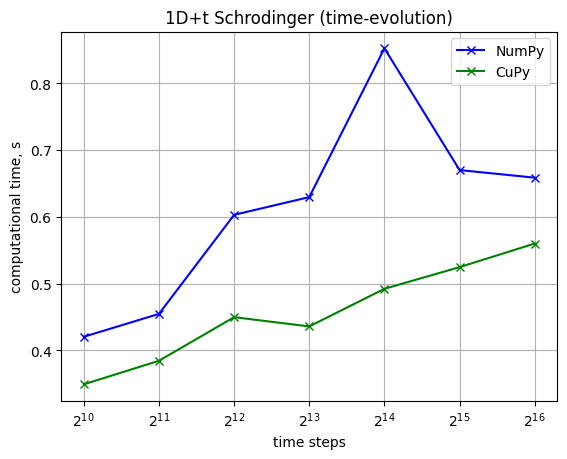

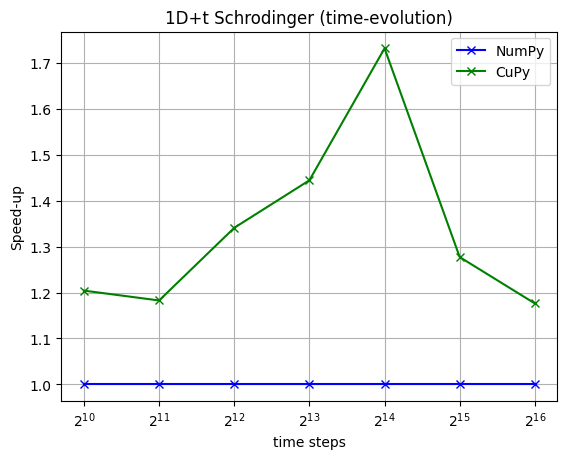

In [ ]:

plt.plot(powers, CPU, label='NumPy', marker='x', color='blue')
plt.plot(powers, GPU, label='CuPy', marker='x', color='green')
plt.xlabel("time steps")
plt.ylabel("computational time, s")
plt.title("1D+t Schrodinger (time-evolution)")
plt.xscale('log', base=2)
plt.legend()
plt.grid(True)
plt.show()

# @jit.rawkernel()
# def schrodingerGPU(psi, U):
#     bid = jit.blockIdx.z * jit.gridDim.x * jit.gridDim.y + \
#           jit.blockIdx.y * jit.gridDim.x + jit.blockIdx.x

#     tid = jit.threadIdx.z * jit.blockDim.x * jit.blockDim.y + \
#           jit.threadIdx.y * jit.blockDim.x + jit.threadIdx.x

#     gid = tid + bid * jit.blockDim.x * jit.blockDim.y * jit.blockDim.z

#     power = gid

#     U = cp.linalg.matrix_power(U, power)
#     psi = cp.matmul(U, psi)


plt.plot(powers, CPU/CPU, label='NumPy', marker='x', color='blue')
plt.plot(powers, CPU/GPU, label='CuPy', marker='x', color='green')
plt.xlabel("time steps")
plt.ylabel("Speed-up")
plt.title("1D+t Schrodinger (time-evolution)")
plt.xscale('log', base=2)
plt.legend()
plt.grid(True)
plt.show()

# schrodingerGPU((1,), (1024,), (psi, U))
# psi

In [ ]:
num_of_N = [100, 1000, 1500, 2000, 2500, 3000]
CPU = []
GPU = []
for N in num_of_N:

    x, dx = np.linspace(-80, +80, N, endpoint=False, retstep=True)
    T, r = 0.20, 3/4
    k1 = root_scalar(lambda a: transmission_probability(0.5*r, 0.5, a) - T,
                    bracket=(0.0, 10.0)).root
    a = 1.25
    V0 = ((k1 / a)**2) / 2
    E = r * V0
    x0, sigma0, p0 = -48.0, 3.0, np.sqrt(2*E)
    psi = gaussian_wavepacket(x, x0=x0, sigma0=sigma0, p0=p0)
    V = rectangular_potential_barrier(x, V0, a)
    H = hamiltonian(N, dx, V=V)
    dt = 0.2
    U = time_evolution_operator(H, dt)
    h_U = U
    h_psi = psi
    d_U = cp.asarray(h_U)
    d_psi = cp.asarray(h_psi)

    info = benchmark_CPU(h_U, 1000, h_psi, n_repeat=5, n_warmup=5)
    CPU.append(info.mean())
    # print(f"CPU times: \n mean: {info.mean()*10**3} ms, std: {info.std()*10**3} ms")
    info = benchmark(calculation_GPU,(d_U, 1000, d_psi),n_repeat=5, n_warmup=5)
    GPU.append(info.gpu_times.mean())
    # print(f"GPU times: \n mean:{info.gpu_times.mean()*10**3} ms, std:{info.gpu_times.std()*10**3} ms")
CPU = np.array(CPU)
GPU = np.array(GPU)

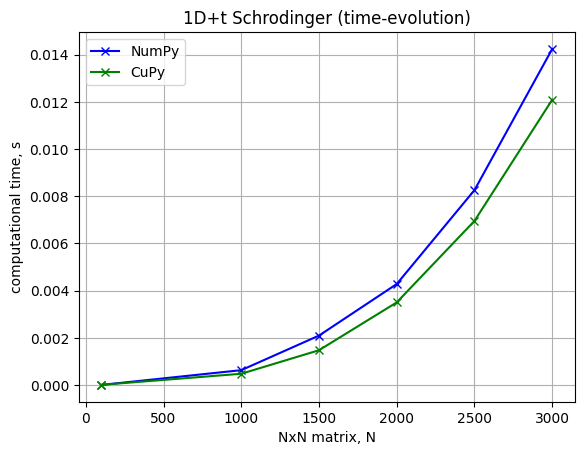

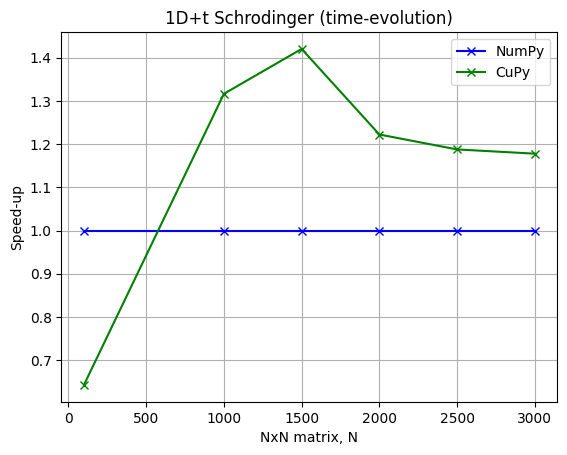

In [ ]:

plt.plot(num_of_N, CPU/1000, label='NumPy', marker='x', color='blue')
plt.plot(num_of_N, GPU/1000, label='CuPy', marker='x', color='green')
plt.xlabel("NxN matrix, N")
plt.ylabel("computational time, s")
plt.title("1D+t Schrodinger (time-evolution)")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(num_of_N, CPU/CPU, label='NumPy', marker='x', color='blue')
plt.plot(num_of_N, CPU/GPU, label='CuPy', marker='x', color='green')
plt.xlabel("NxN matrix, N")
plt.ylabel("Speed-up")
plt.title("1D+t Schrodinger (time-evolution)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# import time

# t1 = time.perf_counter()
# sim = next(generator)
# t2 = time.perf_counter()
# print(f"Calculated in {t2-t1}")
# psi = sim[0]
# t = sim[1]
# plt.plot(x,probability_density(psi))
# plt.xlabel("x")
# plt.ylabel("|psi|^2")
# plt.title("Probability density")
# plt.show()

In [ ]:
# runs = 100
# t1 = time.perf_counter()
# for run in range(runs):
#     sim = next(generator)
# t2 = time.perf_counter()
# print(f"Calculated in {t2-t1}")
# psi = sim[0]
# t = sim[1]
# plt.plot(x,probability_density(psi))
# plt.xlabel("x")
# plt.ylabel("|psi|^2")
# plt.title("Probability density")
# plt.show()

In [ ]:
# psi.shape